In [1]:
### Installing the required packages if not already installed
packages = ['numpy', 'pandas', 'warnings', 'sqlite3', 'sqlite3']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        %pip install {package}

import numpy as np    # For numerical computing
import pandas as pd   # For data manipulation
import sqlite3        # For connecting to SQL database
import matplotlib.pyplot as plt
import os

### Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Setting working directory
os.chdir('/Users/emilwilliamhansen/Desktop/Master-Thesis/Code')

In [2]:
### Extracting the data from the database
conn = sqlite3.connect('Data/data.db')

factor_ret_m = pd.read_sql('SELECT * FROM factors_monthly', conn).set_index('Date').drop(columns='rf')
factor_ret_d = pd.read_sql('SELECT * FROM factors_daily', conn).set_index('Date').drop(columns='rf')
volatility = pd.read_sql('SELECT * FROM volatility', conn).set_index('Date')
variance = pd.read_sql('SELECT * FROM variance', conn).set_index('Date')
volatility_timed_factors = pd.read_sql('SELECT * FROM volatility_timed_factors', conn).set_index('Date')
volatility_managed_factor_ptf_insample = pd.read_sql('SELECT * FROM volatility_managed_factor_ptf_insample', conn).set_index('Date').dropna()
volatility_managed_factor_ptf_outofsample = pd.read_sql('SELECT * FROM volatility_managed_factor_ptf_outofsample', conn).set_index('Date').dropna()

conn.close()

### Fixing the date format
factor_ret_m.index = pd.to_datetime(factor_ret_m.index)
factor_ret_d.index = pd.to_datetime(factor_ret_d.index)
volatility.index = pd.to_datetime(volatility.index)
variance.index = pd.to_datetime(variance.index)
volatility_timed_factors.index = pd.to_datetime(volatility_timed_factors.index)
volatility_managed_factor_ptf_insample.index = pd.to_datetime(volatility_managed_factor_ptf_insample.index)
volatility_managed_factor_ptf_outofsample.index = pd.to_datetime(volatility_managed_factor_ptf_outofsample.index)

### Restricting data to after 1983-02
factor_ret_m = factor_ret_m.loc['1993-02':]
factor_ret_d = factor_ret_d.loc['1993-02':]
volatility = volatility.loc['1993-02':]
variance = variance.loc['1993-02':]
volatility_timed_factors = volatility_timed_factors.loc['1993-02':]
volatility_managed_factor_ptf_insample = volatility_managed_factor_ptf_insample.loc['1993-02':]
volatility_managed_factor_ptf_outofsample = volatility_managed_factor_ptf_outofsample.loc['1993-02':]

**Information**

In this section of the code, we will sort the returns into terciles based on the volatility in $t-1$. Our goal is to try to see if the $\sigma_{t-1}$ changes the risk-adjusted relationship. We will first use the market volatility, then look at the individual factor volatility.

# Market volatility

In [3]:
### Categorising market vol as low, medium, high
terciles = volatility['VW'].quantile([1/3, 2/3])
market_vol = pd.cut(volatility['VW'], bins=[-np.inf, terciles.iloc[0], terciles.iloc[1], np.inf], labels=['low', 'medium', 'high']).shift(1)

### Gettting the factor returns and sharpe ratios for each category
low_ret = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
medium_ret = low_ret.copy()
high_ret = low_ret.copy()
low_sharpe = low_ret.copy()
medium_sharpe = low_ret.copy()
high_sharpe = low_ret.copy()

### Running a loop
for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        short_date = date.strftime('%Y-%m')
        if market_vol.loc[date] == 'low':
            low_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            low_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        elif market_vol.loc[date] == 'medium':
            medium_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            medium_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        else:
            high_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            high_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)

In [4]:
### Saving the average returns and sharpe ratios for each category in a dataframe
avg_sharpe = pd.DataFrame(index=['Low', 'Medium', 'High'], columns=factor_ret_m.columns)
avg_ret = avg_sharpe.copy()

for factor in factor_ret_m.columns:
    avg_sharpe.loc['Low', factor] = low_sharpe[factor].mean()
    avg_sharpe.loc['Medium', factor] = medium_sharpe[factor].mean()
    avg_sharpe.loc['High', factor] = high_sharpe[factor].mean()
    
    avg_ret.loc['Low', factor] = low_ret[factor].mean()
    avg_ret.loc['Medium', factor] = medium_ret[factor].mean()
    avg_ret.loc['High', factor] = high_ret[factor].mean()

avg_sharpe

,VW,EW,SMB,HML,UMD,BAB
Low,1.624171,2.046534,0.519266,0.412468,2.023978,2.348401
Medium,2.243466,2.65373,0.366251,1.187597,0.971789,1.913401
High,1.723827,2.057697,0.520797,-0.431725,1.161921,1.103002


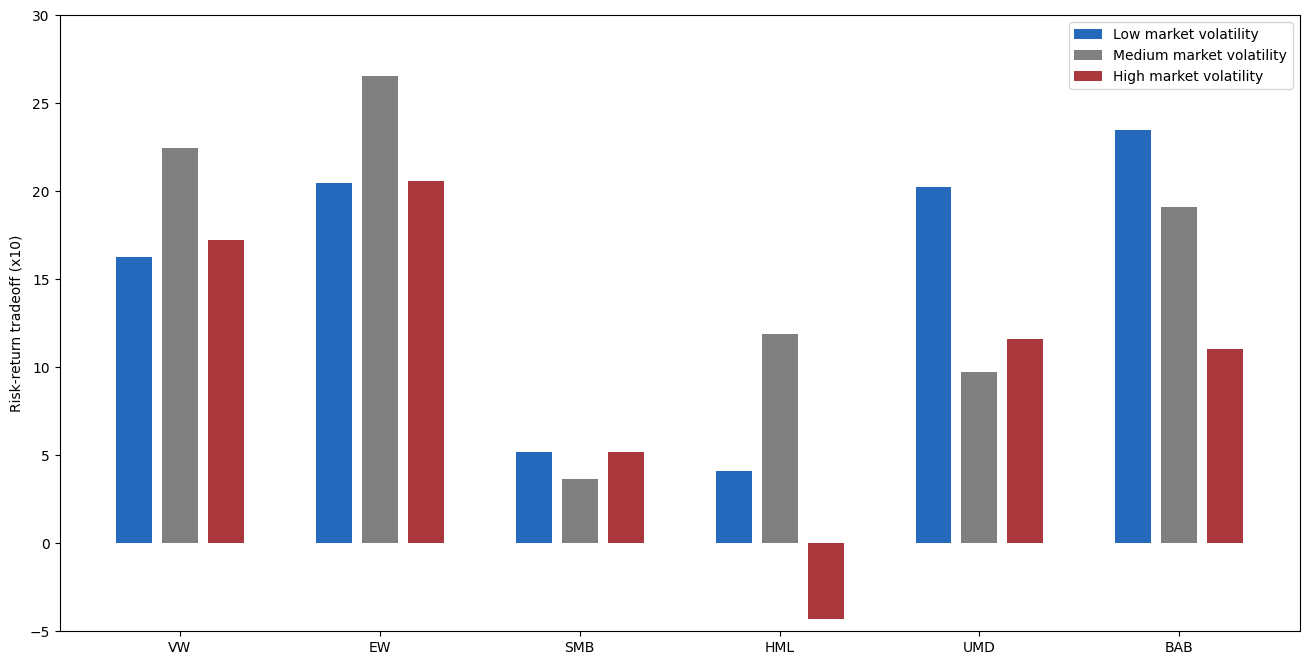

In [5]:
# Plot settings
bar_width = 0.18  # Reduced bar width to add gap
gap = 0.05  # Gap between bars
x = np.arange(len(avg_sharpe.columns))  # Bar positions
colors = {'Low': '#2469bc', 'Medium': 'grey', 'High': '#a9373b'}

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each risk level
for i, risk in enumerate(avg_sharpe.index):
    ax.bar(x + (i - 1) * (bar_width + gap), avg_sharpe.loc[risk] * 10, width=bar_width, label=f'{risk} market volatility', color=colors[risk])

# Labels and legend
ax.set_ylabel('Risk-return tradeoff (x10)')
ax.set_xticks(x)
ax.set_xticklabels(avg_sharpe.columns)
ax.legend()

# Set y-axis to display only integers
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Set y-axis limits and intervals
ax.set_ylim(-5, 30)
ax.set_yticks(np.arange(-5, 35, 5))

### Saving the plot
plt.savefig('Plots/avg_risk-ret_during_diff_marketvol.png')

plt.show()

# Factor volatility

In [6]:
### Categorising market vol as low, medium, high
terciles = volatility.quantile([1/3, 2/3])
vol_cat = pd.DataFrame(index=volatility.index, columns=volatility.columns)
for factor in factor_ret_m.columns:
    vol_cat[factor] = pd.cut(volatility[factor], bins=[-np.inf, terciles[factor].iloc[0], terciles[factor].iloc[1], np.inf], labels=['low', 'medium', 'high']).shift(1)

### Gettting the factor returns and sharpe ratios for each category
low_ret = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
medium_ret = low_ret.copy()
high_ret = low_ret.copy()
low_sharpe = low_ret.copy()
medium_sharpe = low_ret.copy()
high_sharpe = low_ret.copy()

### Running a loop
for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        short_date = date.strftime('%Y-%m')
        if vol_cat.loc[date, factor] == 'low':
            low_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            low_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        elif vol_cat.loc[date, factor] == 'medium':
            medium_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            medium_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        else:
            high_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            high_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)

### Saving the average returns and sharpe ratios for each category in a dataframe
avg_sharpe = pd.DataFrame(index=['Low', 'Medium', 'High'], columns=factor_ret_m.columns)
avg_ret = avg_sharpe.copy()

for factor in factor_ret_m.columns:
    avg_sharpe.loc['Low', factor] = low_sharpe[factor].mean()
    avg_sharpe.loc['Medium', factor] = medium_sharpe[factor].mean()
    avg_sharpe.loc['High', factor] = high_sharpe[factor].mean()
    
    avg_ret.loc['Low', factor] = low_ret[factor].mean()
    avg_ret.loc['Medium', factor] = medium_ret[factor].mean()
    avg_ret.loc['High', factor] = high_ret[factor].mean()

avg_sharpe

,VW,EW,SMB,HML,UMD,BAB
Low,1.624171,2.499993,0.055256,0.335465,1.149393,1.666973
Medium,2.243466,2.052441,0.879106,0.479139,2.09106,1.679504
High,1.723827,2.203162,0.472734,0.34117,0.928683,2.003682


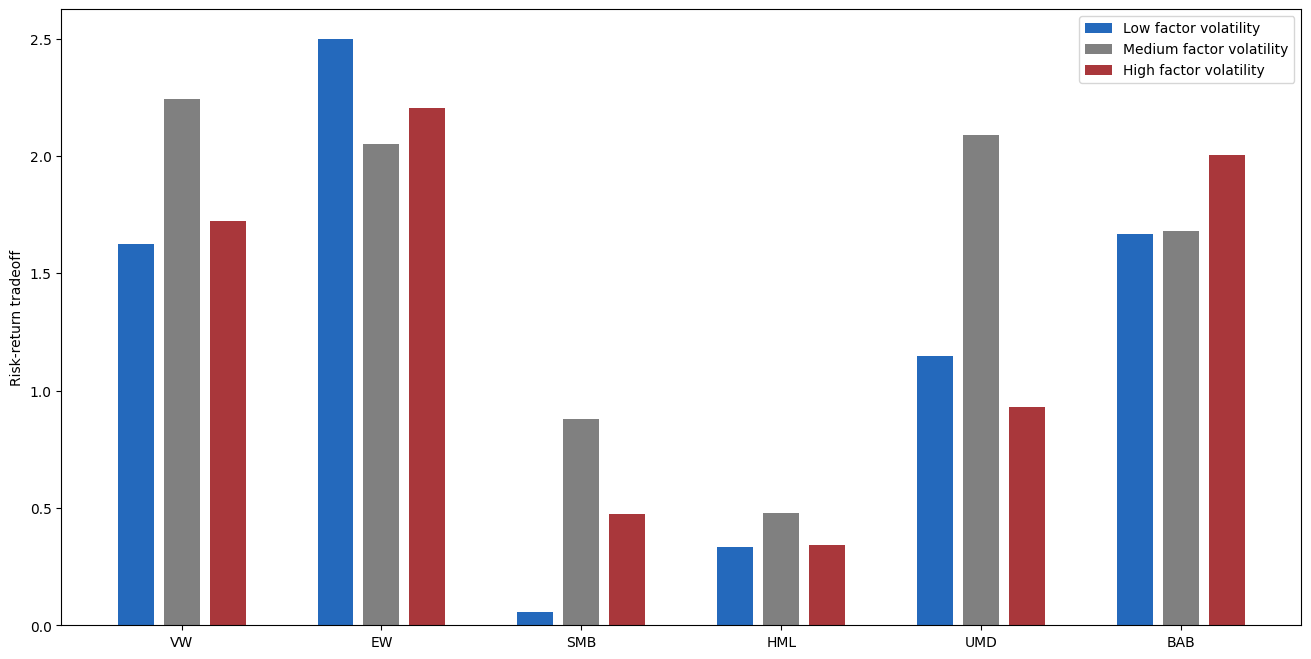

In [7]:
# Plot settings
bar_width = 0.18  # Reduced bar width to add gap
gap = 0.05  # Gap between bars
x = np.arange(len(avg_sharpe.columns))  # Bar positions
colors = {'Low': '#2469bc', 'Medium': 'grey', 'High': '#a9373b'}

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each risk level
for i, risk in enumerate(avg_sharpe.index):
    ax.bar(x + (i - 1) * (bar_width + gap), avg_sharpe.loc[risk], width=bar_width, label=f'{risk} factor volatility', color=colors[risk])

# Labels and legend
ax.set_ylabel('Risk-return tradeoff')
ax.set_xticks(x)
ax.set_xticklabels(avg_sharpe.columns)
ax.legend()

### Saving the plot
plt.savefig('Plots/avg_risk-ret_during_diff_factorvol.png')

plt.show()

#### In-sample

We see that the relationship is not strong, expect for UMD. We will now create the exact same figures, only we will use $\sigma_t$ and not $\sigma_{t-1}$.

In [8]:
### Categorising market vol as low, medium, high
terciles = volatility['VW'].quantile([1/3, 2/3])
market_vol = pd.cut(volatility['VW'], bins=[-np.inf, terciles.iloc[0], terciles.iloc[1], np.inf], labels=['low', 'medium', 'high'])#.shift(1)

### Gettting the factor returns and sharpe ratios for each category
low_ret = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
medium_ret = low_ret.copy()
high_ret = low_ret.copy()
low_sharpe = low_ret.copy()
medium_sharpe = low_ret.copy()
high_sharpe = low_ret.copy()

### Running a loop
for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        short_date = date.strftime('%Y-%m')
        if market_vol.loc[date] == 'low':
            low_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            low_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        elif market_vol.loc[date] == 'medium':
            medium_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            medium_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        else:
            high_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            high_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)

### Saving the average returns and sharpe ratios for each category in a dataframe
avg_sharpe = pd.DataFrame(index=['Low', 'Medium', 'High'], columns=factor_ret_m.columns)
avg_ret = avg_sharpe.copy()

for factor in factor_ret_m.columns:
    avg_sharpe.loc['Low', factor] = low_sharpe[factor].mean()
    avg_sharpe.loc['Medium', factor] = medium_sharpe[factor].mean()
    avg_sharpe.loc['High', factor] = high_sharpe[factor].mean()
    
    avg_ret.loc['Low', factor] = low_ret[factor].mean()
    avg_ret.loc['Medium', factor] = medium_ret[factor].mean()
    avg_ret.loc['High', factor] = high_ret[factor].mean()

avg_sharpe

,VW,EW,SMB,HML,UMD,BAB
Low,3.357945,4.25227,0.709232,0.914691,1.98172,2.301282
Medium,1.884028,2.329408,0.511804,0.547228,1.525399,1.680917
High,0.347395,0.173757,0.186464,-0.305551,0.648082,1.370687


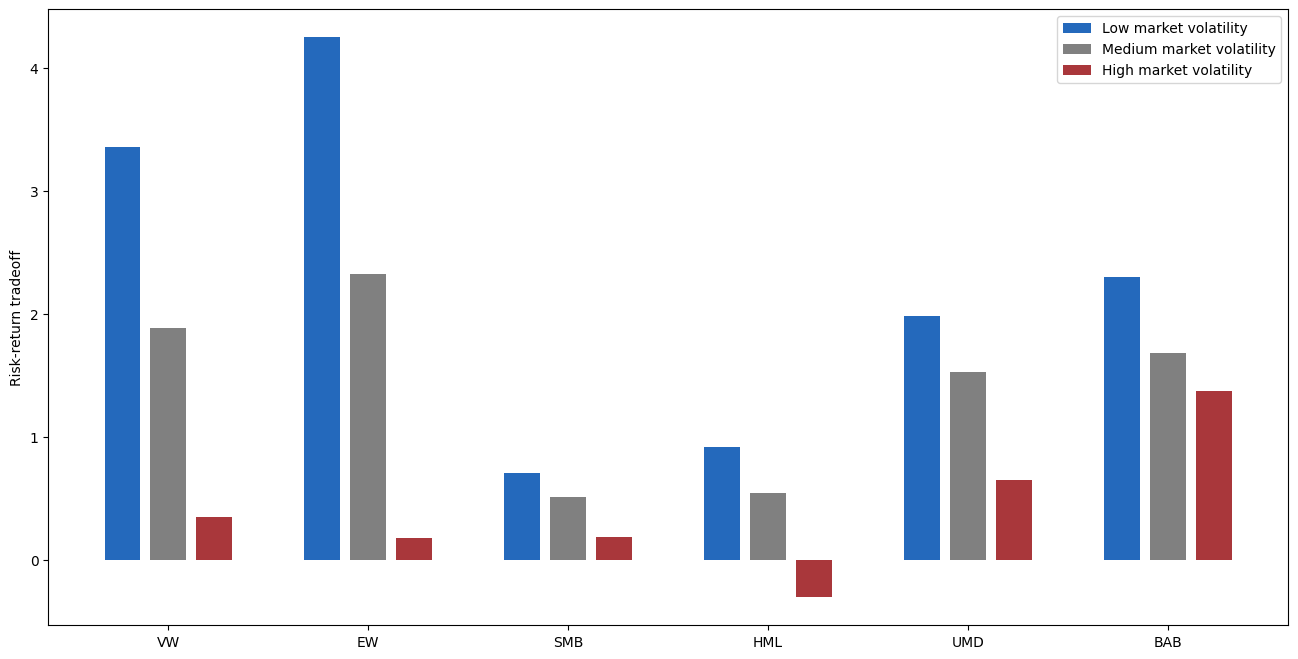

In [9]:
# Plot settings
bar_width = 0.18  # Reduced bar width to add gap
gap = 0.05  # Gap between bars
x = np.arange(len(avg_sharpe.columns))  # Bar positions
colors = {'Low': '#2469bc', 'Medium': 'grey', 'High': '#a9373b'}

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each risk level
for i, risk in enumerate(avg_sharpe.index):
    ax.bar(x + (i - 1) * (bar_width + gap), avg_sharpe.loc[risk], width=bar_width, label=f'{risk} market volatility', color=colors[risk])

# Labels and legend
ax.set_ylabel('Risk-return tradeoff')
ax.set_xticks(x)
ax.set_xticklabels(avg_sharpe.columns)
ax.legend()

### Saving the plot
plt.savefig('Plots/avg_risk-ret_during_diff_marketvol_insample.png')

plt.show()

In [10]:
### Categorising market vol as low, medium, high
terciles = volatility.quantile([1/3, 2/3])
vol_cat = pd.DataFrame(index=volatility.index, columns=volatility.columns)
for factor in factor_ret_m.columns:
    vol_cat[factor] = pd.cut(volatility[factor], bins=[-np.inf, terciles[factor].iloc[0], terciles[factor].iloc[1], np.inf], labels=['low', 'medium', 'high'])#.shift(1)

### Gettting the factor returns and sharpe ratios for each category
low_ret = pd.DataFrame(index=factor_ret_m.index, columns=factor_ret_m.columns)
medium_ret = low_ret.copy()
high_ret = low_ret.copy()
low_sharpe = low_ret.copy()
medium_sharpe = low_ret.copy()
high_sharpe = low_ret.copy()

### Running a loop
for factor in factor_ret_m.columns:
    for date in factor_ret_m.index:
        short_date = date.strftime('%Y-%m')
        if vol_cat.loc[date, factor] == 'low':
            low_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            low_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        elif vol_cat.loc[date, factor] == 'medium':
            medium_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            medium_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)
        else:
            high_ret.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() * 252
            high_sharpe.loc[date, factor] = factor_ret_d.loc[short_date, factor].mean() / factor_ret_d.loc[short_date, factor].std() * np.sqrt(252)

### Saving the average returns and sharpe ratios for each category in a dataframe
avg_sharpe = pd.DataFrame(index=['Low', 'Medium', 'High'], columns=factor_ret_m.columns)
avg_ret = avg_sharpe.copy()

for factor in factor_ret_m.columns:
    avg_sharpe.loc['Low', factor] = low_sharpe[factor].mean()
    avg_sharpe.loc['Medium', factor] = medium_sharpe[factor].mean()
    avg_sharpe.loc['High', factor] = high_sharpe[factor].mean()
    
    avg_ret.loc['Low', factor] = low_ret[factor].mean()
    avg_ret.loc['Medium', factor] = medium_ret[factor].mean()
    avg_ret.loc['High', factor] = high_ret[factor].mean()

avg_sharpe

,VW,EW,SMB,HML,UMD,BAB
Low,3.357945,3.928101,0.54546,0.243078,1.652982,2.09384
Medium,1.884028,2.526317,0.169369,0.132609,1.664857,1.895273
High,0.347395,0.302605,0.68991,0.777338,0.838486,1.365502


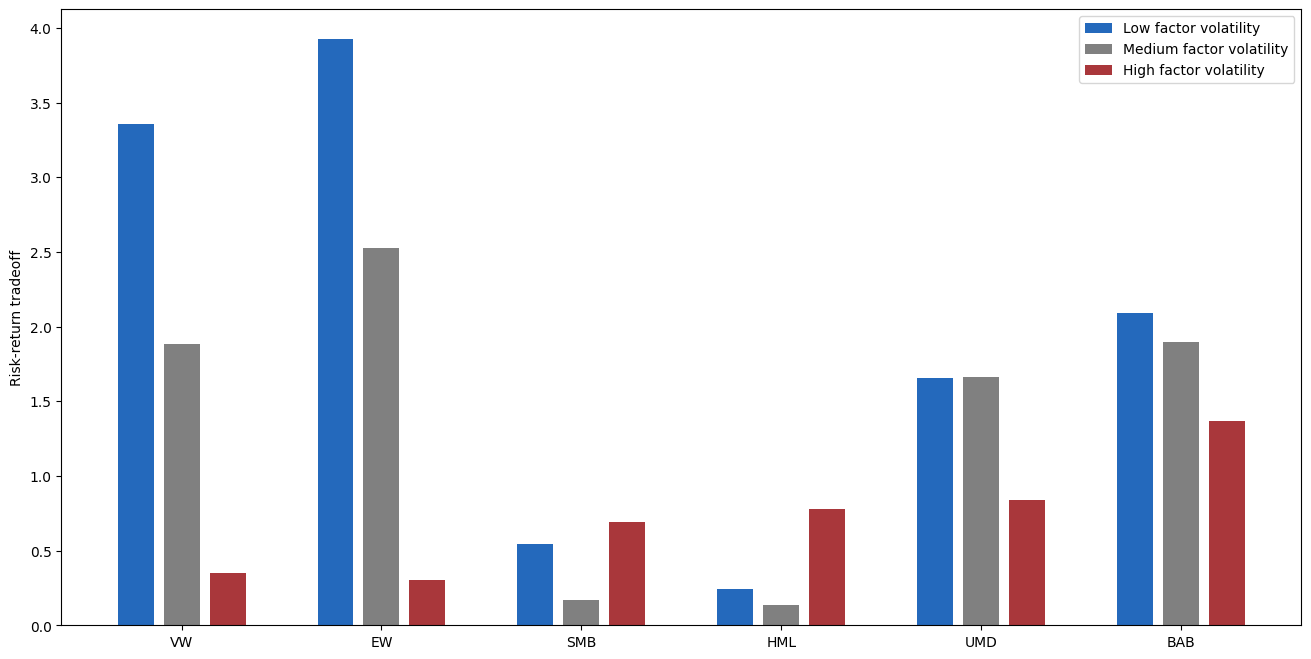

In [11]:
# Plot settings
bar_width = 0.18  # Reduced bar width to add gap
gap = 0.05  # Gap between bars
x = np.arange(len(avg_sharpe.columns))  # Bar positions
colors = {'Low': '#2469bc', 'Medium': 'grey', 'High': '#a9373b'}

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each risk level
for i, risk in enumerate(avg_sharpe.index):
    ax.bar(x + (i - 1) * (bar_width + gap), avg_sharpe.loc[risk], width=bar_width, label=f'{risk} factor volatility', color=colors[risk])

# Labels and legend
ax.set_ylabel('Risk-return tradeoff')
ax.set_xticks(x)
ax.set_xticklabels(avg_sharpe.columns)
ax.legend()

### Saving the plot
plt.savefig('Plots/avg_risk-ret_during_diff_factorvol_insample.png')

plt.show()